# Notebook to analyze shelfstrat basecase for 43N f-plane 30 day simulation
Basic animations of relevant surface fields, energectics, and numerical mixing are examined. Eventually develop the code presented here so it may be applied to many simulations.  

In [69]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr

from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

In [70]:
path = '/d1/shared/shelfstrat_wind/43N/shelf_dx_500_uwind_0_f_43N/shelf_dx_500_uwind_0_f_43N_his.nc' #History file
ds = xroms.open_netcdf(path)
ds, grid = xroms.roms_dataset(ds)

path1 = '/d1/shared/shelfstrat_wind/43N/shelf_dx_500_uwind_0_f_43N/shelf_dx_500_uwind_0_f_43N_avg.nc' #Average file
ds_avg = xroms.open_netcdf(path1)
ds_avg, grid_avg = xroms.roms_dataset(ds_avg)

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/core/indexing.py:422: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/d2/home/dylan/.conda/envs/copano/lib/pyth

# Plot initial vs final salt, $\nabla_H s|$, $\zeta/f$, and $\delta/f$

In [3]:
def surface_vorticity(ds, grid):
    '''
Calculates the surface vertical vorticity normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
rvort_psi: Normalized vorticity on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudy = grid.derivative(u, 'Y')
    dudy = xroms.to_rho(dudy, grid)
    dvdx = grid.derivative(v, 'X')
    dvdx = xroms.to_rho(dvdx, grid)

    rvort_rho = (dvdx-dudy)/ds.f
    
    return rvort_rho 

# def surface_div(ds, grid):
#     '''
# Calculates the surface divergence normalized by 
# the Coriolis frequency. 
# ----
# Inputs:
# ds - Xarray Dataset
# grid - XGCM grid object 
# ----
# Outputs:
# rvort_psi: Normalized vorticity on the psi points 

#     '''
#     u = ds.u.isel(s_rho=-1)
#     v = ds.v.isel(s_rho=-1)

#     dudx = grid.derivative(u, 'X')
#     # dudx = xroms.to_rho(dudx, grid)
#     dvdy = grid.derivative(v, 'Y')
#     # dvdy = xroms.to_rho(dvdx, grid)

#     div_rho = (dudx+dvdy)/ds.f
    
#     return div_rho 

def surface_saltgradmag(ds, grid):
    '''
Calculates the surface horizontal salinity gradient magnitude normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
sgradmag: horizontal salinity gradient magnitude on the psi points

    '''
    s = ds.salt.isel(s_rho=-1)

    dsdx = grid.derivative(s, 'X', boundary = 'extend')
    dsdx_psi = xroms.to_rho(dsdx, grid)
    dsdy = grid.derivative(s, 'Y', boundary = 'extend')
    dsdy_psi = xroms.to_rho(dsdy, grid)
    
    sgradmag = (dsdx_psi**2+dsdy_psi**2)**(1/2)
    
    return sgradmag

sgradmag = surface_saltgradmag(ds, grid)
rv = surface_vorticity(ds, grid)
# div = surface_div(ds, grid)
vortfinal = rv[-1].load()
# divfinal = div[-1].load()
sgradfinal = sgradmag[-1].load()

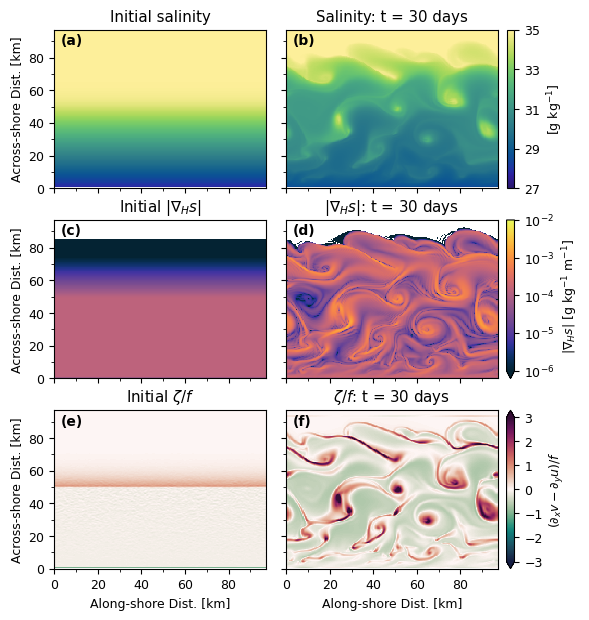

In [4]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(3,2, figsize = (7,7))

#salt
mappable = ax[0,0].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, ds.salt[0,-1,1:], cmap = cmo.haline, vmin = 27, vmax = 35)
mappable = ax[0,1].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, ds.salt[-1,-1,1:], cmap = cmo.haline, vmin = 27, vmax = 35)
cbar = fig.colorbar(mappable, ax = ax[0,1], label = '', pad = 0.03, ticks = [27, 29, 31, 33, 35],)
cbar.ax.set_ylabel(r'[g kg$^{-1}$]')

mappable = ax[1,0].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, np.log10(sgradmag[0,1:].where(sgradmag[0,1:]>1e-7)), cmap = cmo.thermal, vmin = -6, vmax = -2)
mappable = ax[1,1].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, np.log10(sgradfinal[1:].where(sgradfinal[1:]>1e-7)), cmap = cmo.thermal, vmin = -6, vmax = -2)
cbar = fig.colorbar(mappable, ax = ax[1,1], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%d}$'), pad = 0.03)
cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

mappable = ax[2,0].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, rv[0,1:], cmap = cmo.curl, vmin = -3, vmax = 3)
mappable = ax[2,1].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, vortfinal[1:], cmap = cmo.curl, vmin = -3, vmax = 3)
cbar = fig.colorbar(mappable, ax = ax[2,1], label = '', extend = 'both', pad = 0.03, ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'$(\partial_x v - \partial_y u)/f$')

for i in range(3):
    for j in range(2):
        ax[i,j].set(xlim=[0,97], ylim=[0,97], aspect = 0.75)
        ax[i,0].set_ylabel('Across-shore Dist. [km]')
        ax[2,j].set_xlabel('Along-shore Dist. [km]')
        ax[i,1].set_yticklabels([])
        minor_locator = AutoMinorLocator(2)
        ax[i,j].xaxis.set_minor_locator(minor_locator)
        ax[i,j].yaxis.set_minor_locator(minor_locator)

for i in range(2):
    for j in range(2):
        ax[i,j].set_xticklabels([])

ax[0,0].set_title(r'Initial salinity')
ax[0,1].set_title(r'Salinity: t = 30 days')
ax[1,0].set_title(r'Initial $|\nabla_H s|$')
ax[1,1].set_title(r'$|\nabla_H s|$: t = 30 days')
ax[2,0].set_title(r'Initial $\zeta/f$')
ax[2,1].set_title(r'$\zeta/f$: t = 30 days')
        
ax[0,0].annotate('(a)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
ax[0,1].annotate('(b)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
ax[1,0].annotate('(c)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
ax[1,1].annotate('(d)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
ax[2,0].annotate('(e)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
ax[2,1].annotate('(f)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
# fig.constrained_layout()
plt.subplots_adjust(wspace = -0.2)
# plt.savefig('shelfstrat_overview.jpg', dpi = 300, bbox_inches='tight')

# Repeat but plot every 10 days

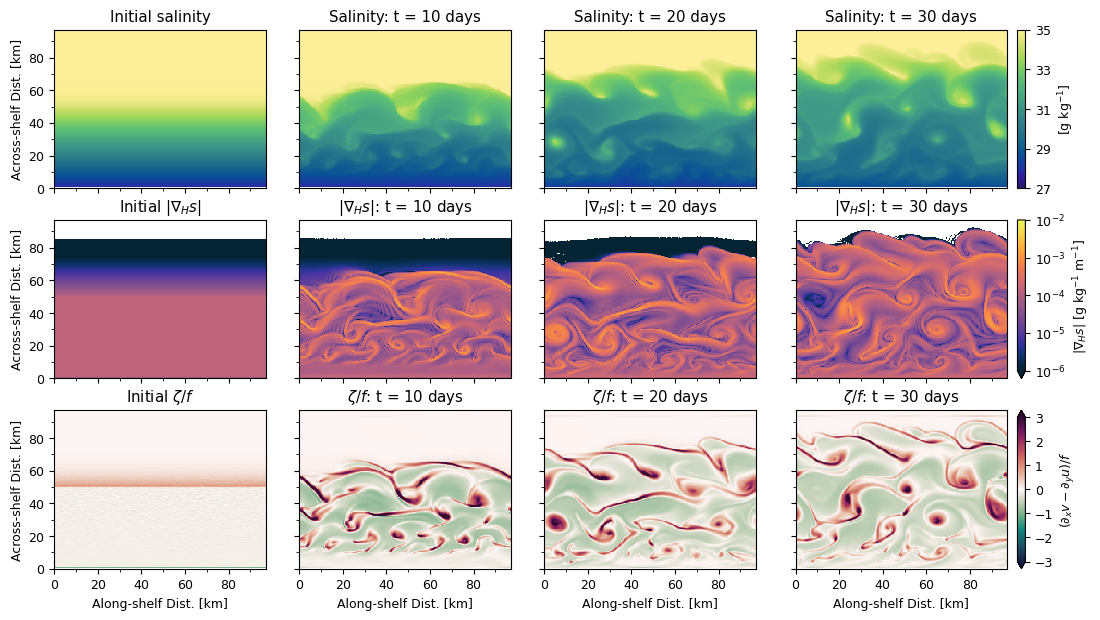

In [5]:
plt.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(3,4, figsize = ((7/2)*4,7), constrained_layout = False)

#salt
mappable1 = ax[0,0].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, ds.salt[0,-1,1:], cmap = cmo.haline, vmin = 27, vmax = 35)
mappable2 = ax[0,1].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, ds.salt[240,-1,1:], cmap = cmo.haline, vmin = 27, vmax = 35)
mappable3 = ax[0,2].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, ds.salt[240*2,-1,1:], cmap = cmo.haline, vmin = 27, vmax = 35)
mappable4 = ax[0,3].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, ds.salt[-1,-1,1:], cmap = cmo.haline, vmin = 27, vmax = 35)

cbar = fig.colorbar(mappable4, ax = ax[0,3], label = '', pad = 0.03, ticks = [27, 29, 31, 33, 35],)
cbar.ax.set_ylabel(r'[g kg$^{-1}$]')

mappable5 = ax[1,0].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, np.log10(sgradmag[0,1:].where(sgradmag[0,1:]>1e-7)), cmap = cmo.thermal, vmin = -6, vmax = -2)
mappable6 = ax[1,1].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, np.log10(sgradmag[240,1:].where(sgradmag[240,1:]>1e-7)), cmap = cmo.thermal, vmin = -6, vmax = -2)
mappable7 = ax[1,2].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, np.log10(sgradmag[240*2,1:].where(sgradmag[240*2,1:]>1e-7)), cmap = cmo.thermal, vmin = -6, vmax = -2)
mappable8 = ax[1,3].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, np.log10(sgradfinal[1:].where(sgradfinal[1:]>1e-7)), cmap = cmo.thermal, vmin = -6, vmax = -2)
cbar = fig.colorbar(mappable8, ax = ax[1,3], label = '', extend = 'min', format=tick.FormatStrFormatter('$10^{%d}$'), pad = 0.03)
cbar.ax.set_ylabel(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

mappable9 = ax[2,0].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, rv[0,1:], cmap = cmo.curl, vmin = -3, vmax = 3)
mappable10 = ax[2,1].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, rv[240,1:], cmap = cmo.curl, vmin = -3, vmax = 3)
mappable11 = ax[2,2].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, rv[240*2,1:], cmap = cmo.curl, vmin = -3, vmax = 3)
mappable12 = ax[2,3].pcolormesh(ds.x_rho[1:]/1000, ds.y_rho[1:]/1000, vortfinal[1:], cmap = cmo.curl, vmin = -3, vmax = 3)
cbar = fig.colorbar(mappable12, ax = ax[2,3], label = '', extend = 'both', pad = 0.03, ticks = [-3,-2,-1,0,1,2,3])
cbar.ax.set_ylabel(r'$(\partial_x v - \partial_y u)/f$')

for i in range(3):
    for j in range(4):
        ax[i,j].set(xlim=[0,97], ylim=[0,97], aspect = 0.75)
        ax[i,0].set_ylabel('Across-shelf Dist. [km]')
        ax[2,j].set_xlabel('Along-shelf Dist. [km]')
        ax[i,1].set_yticklabels([])
        ax[i,2].set_yticklabels([])
        ax[i,3].set_yticklabels([])
        minor_locator = AutoMinorLocator(2)
        ax[i,j].xaxis.set_minor_locator(minor_locator)
        ax[i,j].yaxis.set_minor_locator(minor_locator)

for i in range(2):
    for j in range(4):
        ax[i,j].set_xticklabels([])

ax[0,0].set_title(r'Initial salinity')
ax[0,1].set_title(r'Salinity: t = 10 days')
ax[0,2].set_title(r'Salinity: t = 20 days')
ax[0,3].set_title(r'Salinity: t = 30 days')
ax[1,0].set_title(r'Initial $|\nabla_H s|$')
ax[1,1].set_title(r'$|\nabla_H s|$: t = 10 days')
ax[1,2].set_title(r'$|\nabla_H s|$: t = 20 days')
ax[1,3].set_title(r'$|\nabla_H s|$: t = 30 days')
ax[2,0].set_title(r'Initial $\zeta/f$')
ax[2,1].set_title(r'$\zeta/f$: t = 10 days')
ax[2,2].set_title(r'$\zeta/f$: t = 20 days')
ax[2,3].set_title(r'$\zeta/f$: t = 30 days')
        
# ax[0,0].annotate('(a)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
# ax[0,1].annotate('(b)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
# ax[1,0].annotate('(c)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
# ax[1,1].annotate('(d)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
# ax[2,0].annotate('(e)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
# ax[2,1].annotate('(f)', xy = (3, 88), color = 'k', fontsize = 10, fontweight='bold')
# fig.constrained_layout()
plt.subplots_adjust(wspace = -0.3)
# plt.savefig('shelfstrat_overview.jpg', dpi = 300, bbox_inches='tight')

# Calculate the volume-integrated eddy kinetic energy, mean kinetic energy, and total kinetic energy as defined in Hetland (2017) JPO
#### $u = \overline{u}+u^\prime$, where $\overline{u}= \frac{1}{L} \int_0^L u \, dx$ is the alongshore mean.
#### $EKE = \frac{1}{2}(u^{\prime^2}+v^2) \xrightarrow{} \iiint_V EKE \, dV = \iiint_V \frac{1}{2}(u^{\prime^2}+v^2) \, dV$ 
#### $MKE = \iiint \frac{1}{2} (\overline{u})^2 \, dV$ 
#### $TKE = \iiint \frac{1}{2} (u^2+v^2) \, dV$.
Normalize the energy for plotting by the initial mean kinetic energy. The normalization options are not obvious; the initial MKE is chosen because it is strongly correlated to the horizontal slope burger number 

In [54]:
#Slice over the plume, 0-50 km across-shelf
etaslice = slice(1,100)
xislice = slice(1,-1)
#Print rho points to double check, psi points are +250 m 
ds.y_rho.isel(eta_rho = etaslice, xi_rho = xislice).values

array([[  750.,   750.,   750., ...,   750.,   750.,   750.],
       [ 1250.,  1250.,  1250., ...,  1250.,  1250.,  1250.],
       [ 1750.,  1750.,  1750., ...,  1750.,  1750.,  1750.],
       ...,
       [48750., 48750., 48750., ..., 48750., 48750., 48750.],
       [49250., 49250., 49250., ..., 49250., 49250., 49250.],
       [49750., 49750., 49750., ..., 49750., 49750., 49750.]])

In [55]:
def energy_vintegrated(ds,grid,xislice,etaslice):
    '''
Calculates volume-integrated eddy kinetic energy,
mean kinetic energy, and total kinetic energy as defined
by Hetland (2017) JPO. 
    '''
    u = xroms.to_rho(ds.u, grid)
    u = u.isel(eta_rho = etaslice, xi_rho = xislice)
    v = xroms.to_rho(ds.v, grid)
    v = v.isel(eta_rho = etaslice, xi_rho = xislice)
    ubar = u.mean('xi_rho')
    uprime = u-ubar
    vprime = v
    
    #Eddy kinetic energy
    eke = 0.5*(uprime**2 + vprime**2)
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    eke_int = (eke*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    
    #Mean kinetic energy
    mke = 0.5*ubar**2
    mke_int = (mke*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    
    #Total kinetic energy 
    tke = 0.5*(u**2+v**2)
    tke_int = (tke*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    
    return eke_int, mke_int, tke_int
eke_int, mke_int, tke_int = energy_vintegrated(ds,grid,xislice,etaslice)

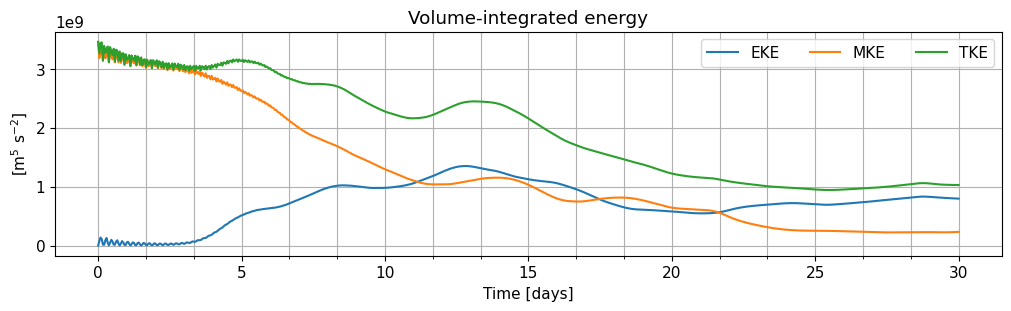

In [56]:
time = np.arange(0,721)/24 #Crude time vector, could do this a fancier way but meh. 
fig, ax = plt.subplots(1, figsize = (10,3), constrained_layout = True)

plt.plot(time, eke_int, label = r'EKE')
plt.plot(time, mke_int, label = r'MKE')
plt.plot(time, tke_int, label = r'TKE')

plt.grid(which = 'both')
plt.legend(ncol = 3)
plt.title(r'Volume-integrated energy')
plt.xlabel('Time [days]')
plt.ylabel('[m$^5$ s$^{-2}$]')
# plt.xticks(np.arange(0,11))
minor_locator = AutoMinorLocator(3)
ax.xaxis.set_minor_locator(minor_locator)

# Now clean this plot up. Normalize so the starting value of each quantity is equal to one

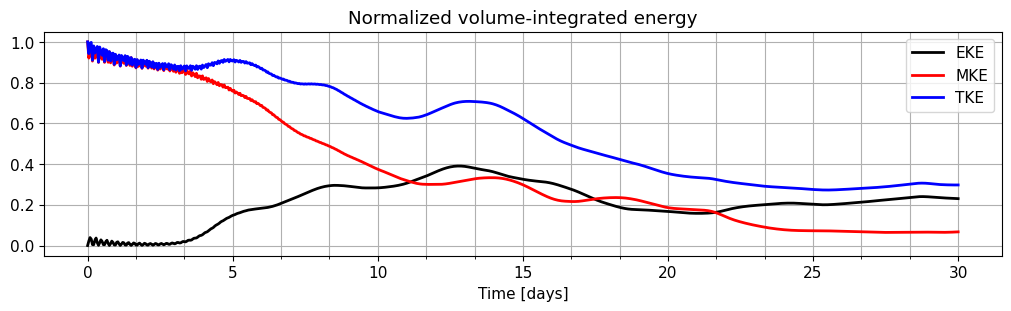

In [57]:
plt.rcParams.update({'font.size': 11})
time = np.arange(0,721)/24 #Crude time vector, could do this a fancier way but meh. 
fig, ax = plt.subplots(1, figsize = (10,3), constrained_layout = True)

plt.plot(time, eke_int/mke_int[0], color = 'k', lw = 2, label = r'EKE')
plt.plot(time, mke_int/mke_int[0], color = 'r', lw = 2, label = r'MKE')
plt.plot(time, tke_int/mke_int[0], color = 'b', lw = 2, label = r'TKE')

plt.grid(which = 'both')
plt.legend()
plt.title(r'Normalized volume-integrated energy')
plt.xlabel('Time [days]')
plt.ylabel('')
# plt.xticks(np.arange(0,11))
minor_locator = AutoMinorLocator(3)
ax.xaxis.set_minor_locator(minor_locator)

# Make volume-weighted histograms of non-dimensional parameters.
#### $M^2 = |\nabla_H b|$, magnitude of lateral buoyancy gradients 
#### $N^2 = \frac{g}{\rho} \frac{\partial \rho}{\partial z}$, buoyancy frequency squared
#### $Ri = N^2f^2M^{-4}$, Richardson number, stratification/shear
#### $S = Nf^{-1}\alpha, \, \alpha = 0.001$, Slope Burger number, stratification/rotation
#### $\delta = SRi^{1/2}$, Bottom slope/isopycnal slope

In [58]:
# rho = xroms.density(ds.temp, ds.salt)
rho = xroms.potential_density(ds.temp, ds.salt)
# sig0 = rho-1000
N2 = xroms.N2(rho, grid, rho0 = 1023)
M2 = xroms.M2(rho, grid, rho0 = 1023)

f = 1e-4
M = np.sqrt(M2)
Ri = N2*f**2*(M**-4)

N = np.sqrt(N2)
alpha = 0.001
S = N*(f**-1)*alpha
Delta = S*(np.sqrt(Ri))

M2sub = M2.isel(eta_rho = etaslice, xi_rho = xislice)
N2sub = N2.isel(eta_rho = etaslice, xi_rho = xislice)
Risub = Ri.isel(eta_rho = etaslice, xi_rho = xislice)
Ssub = S.isel(eta_rho = etaslice, xi_rho = xislice)
Deltasub = Delta.isel(eta_rho = etaslice, xi_rho = xislice)

dV_w = ds.dV_w.isel(eta_rho = etaslice, xi_rho = xislice)

In [59]:
#Now create the histograms
M2bins = np.linspace(-8,-4,100)
M2_hist = histogram(np.log10(M2sub), bins = [M2bins], dim = ['s_w', 'eta_rho', 'xi_rho'], 
                    weights = dV_w, density = 'False').load()

N2bins = np.linspace(-5.5,-1.5,100)
N2sub.name = 'N2'
N2_hist = histogram(np.log10(N2sub), bins = [N2bins], dim = ['s_w', 'eta_rho', 'xi_rho'], 
                    weights = dV_w, density = 'False').load()

Ribins = np.linspace(-1,3,100)
Risub.name = 'Ri'
Ri_hist = histogram(np.log10(Risub), bins = [Ribins], dim = ['s_w', 'eta_rho', 'xi_rho'], 
                    weights = dV_w, density = 'False').load()

Sbins = np.linspace(-2,1,100)
Ssub.name = 'S'
S_hist = histogram(np.log10(Ssub), bins = [Sbins], dim = ['s_w', 'eta_rho', 'xi_rho'], 
                    weights = dV_w, density = 'False').load()

Deltabins = np.linspace(-1.5,1.5,100)
Deltasub.name = 'Delta'
Delta_hist = histogram(np.log10(Deltasub), bins = [Deltabins], dim = ['s_w', 'eta_rho', 'xi_rho'], 
                    weights = dV_w, density = 'False').load()

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in power
  return func(*(_execute_task(a, cache) for a in args))
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packag

# Now plot the histograms and energy to recreate Fig. 7 of Hetland (2017)

(0.0, 30.0)

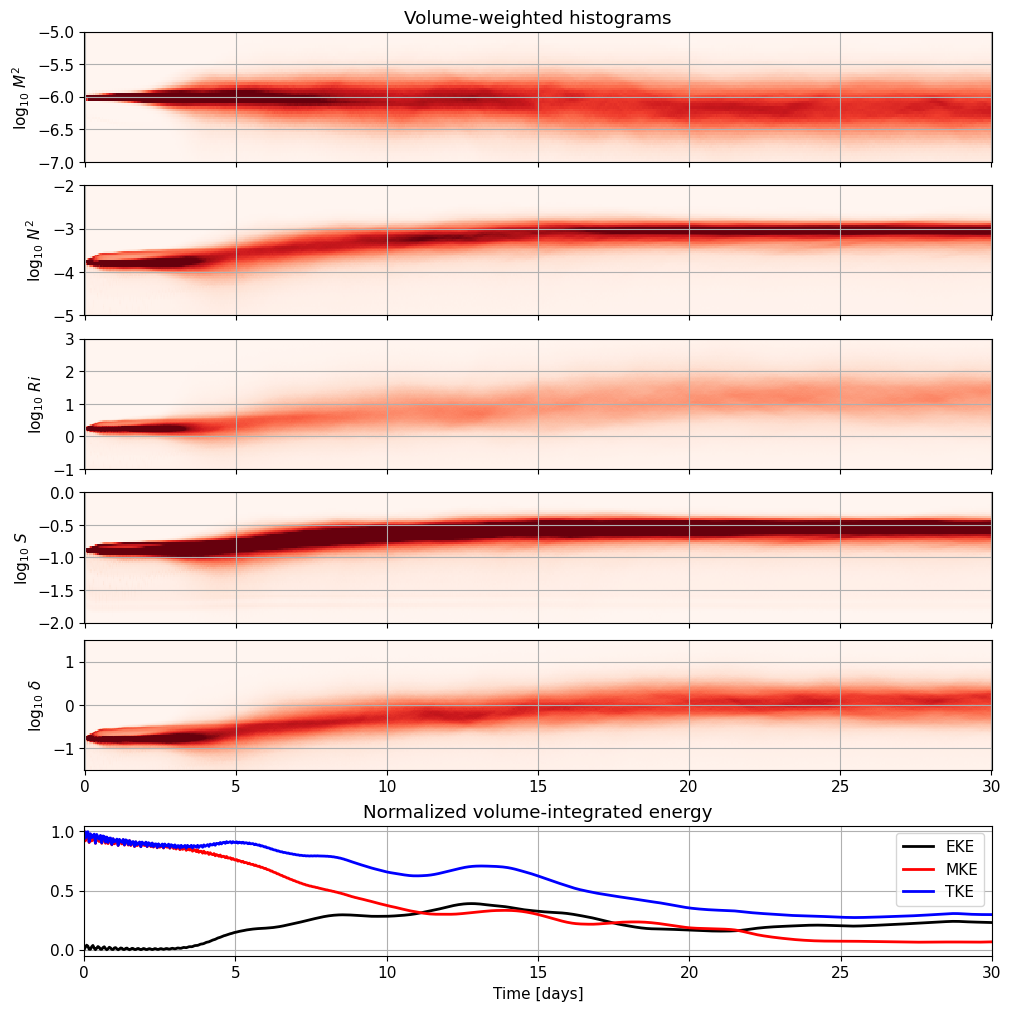

In [68]:
fig, ax = plt.subplots(6, figsize = (10,10), constrained_layout = True)

ax[0].pcolormesh(time, M2_hist.M2_bin, M2_hist.T, cmap = plt.get_cmap('Reds'), vmin = 0, vmax = 1.75)
ax[1].pcolormesh(time, N2_hist.N2_bin, N2_hist.T, cmap = plt.get_cmap('Reds'), vmin = 0, vmax = 1.75)
ax[2].pcolormesh(time, Ri_hist.Ri_bin, Ri_hist.T, cmap = plt.get_cmap('Reds'), vmin = 0, vmax = 1.75)
ax[3].pcolormesh(time, S_hist.S_bin, S_hist.T, cmap = plt.get_cmap('Reds'), vmin = 0, vmax = 1.75)
ax[4].pcolormesh(time, Delta_hist.Delta_bin, Delta_hist.T, cmap = plt.get_cmap('Reds'), vmin = 0, vmax = 1.75)

ax[0].set_ylim(-7,-5)
ax[1].set_ylim(-5,-2)
ax[3].set_ylim(-2,0)
for i in range(5):
    ax[i].grid(which = 'both')
for i in range(4):
    ax[i].set_xticklabels('')
ax[0].set_title('Volume-weighted histograms')

ax[0].set_ylabel(r'$\log_{10} \, \, M^2$')
ax[1].set_ylabel(r'$\log_{10} \, \, N^2$')
ax[2].set_ylabel(r'$\log_{10} \, \, Ri$')
ax[3].set_ylabel(r'$\log_{10} \, \, S$')
ax[4].set_ylabel(r'$\log_{10} \, \, \delta$')
ax[5].plot(time, eke_int/mke_int[0], color = 'k', lw = 2, label = r'EKE')
ax[5].plot(time, mke_int/mke_int[0], color = 'r', lw = 2, label = r'MKE')
ax[5].plot(time, tke_int/mke_int[0], color = 'b', lw = 2, label = r'TKE')

ax[5].grid(which = 'both')
ax[5].legend()
ax[5].set_title(r'Normalized volume-integrated energy')
ax[5].set_xlabel('Time [days]')
ax[5].set_xlim(0,30)

![image.png](attachment:3da4a983-e3ff-4805-9a52-2c206fc6ac16.png,width="600" height="300")
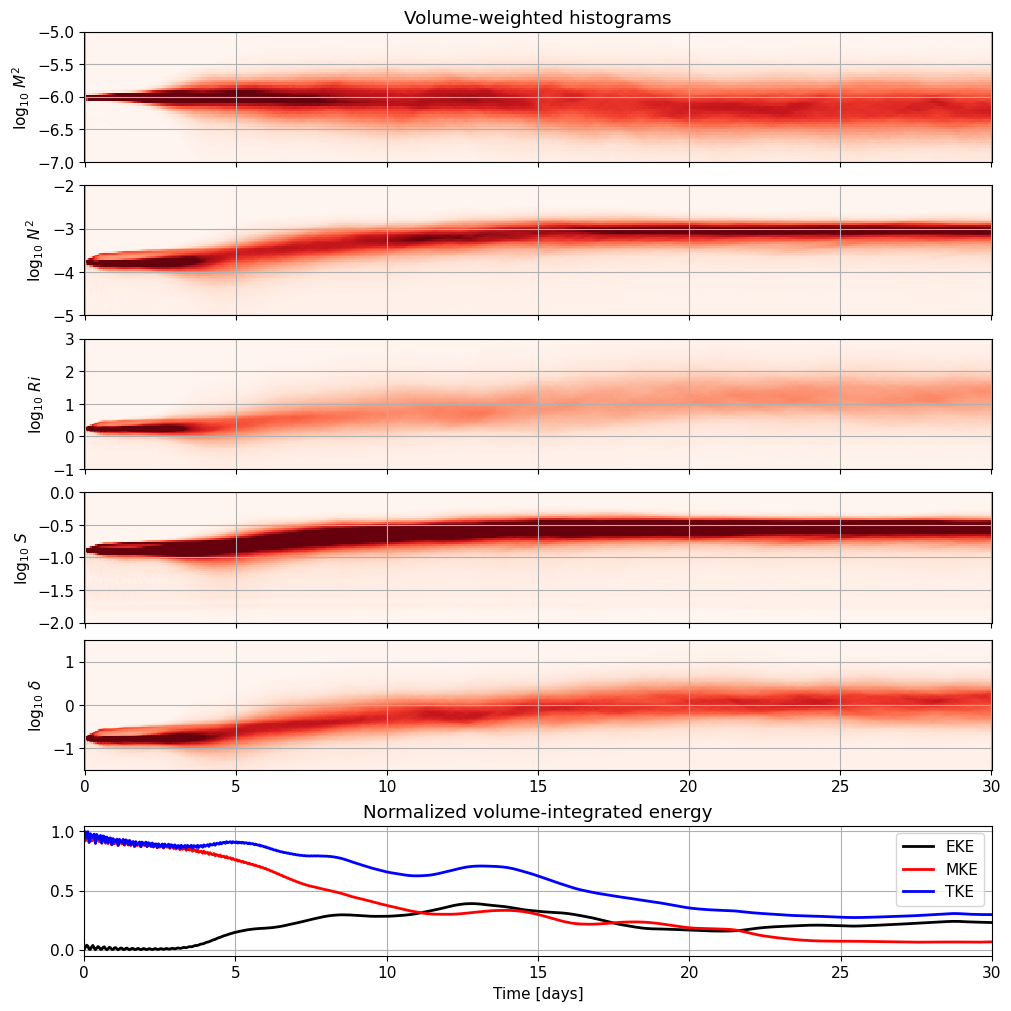

# Parameter space looks very similar to Hetland (2017), with the exception of the initilization shock and $N^2$ being slightly higher at the start of the simulation.
The initial conditions are set right in the initialization file, so should be all good. Assume minor differences are due to output frequency differences compared to Hetland (2017) and other slight differences in model setup 

# Analyze mixing using average files 

In [63]:
def compute_mix(ds, grid):
    '''
Computes volume-integrated physical and numerical mixing for ROMS model output.
    '''
    mnum = ds.dye_03.isel(eta_rho = etaslice, xi_rho = xislice)
    mphy = ds.AKr.isel(eta_rho = etaslice, xi_rho = xislice)
    #Interpolate to the s-rho points 
    mphy = grid.interp(mphy, 'Z')
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    #Load in data for quick plotting
    mnum_int = (mnum*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mphy_int = (mphy*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    
    return mnum_int, mphy_int

mnum_int, mphy_int = compute_mix(ds_avg,grid_avg)

/tmp/ipykernel_29465/1032890050.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[1].set_ylim(0,100)


Text(0, 0.5, '[$\\%$]')

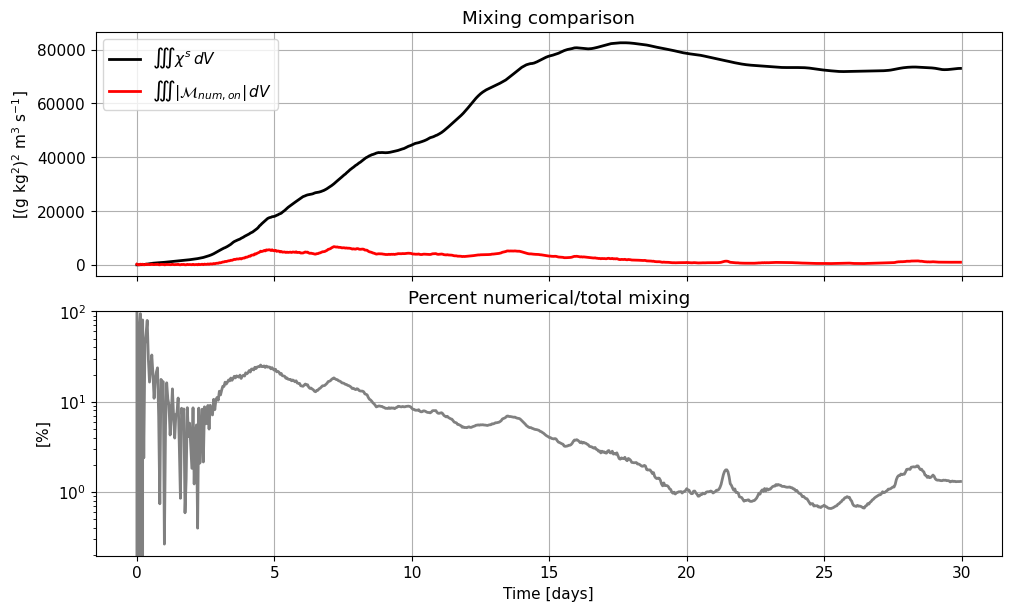

In [64]:
plt.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(2, figsize = (10,6), constrained_layout = True)
mtotal = np.abs(mphy_int)+mnum_int
ax[0].plot(time[:-1], mphy_int, lw = 2, c = 'k', label = r'$\iiint \chi^s \, dV$')
ax[0].plot(time[:-1], np.abs(mnum_int), lw = 2, c = 'r', label = r'$\iiint |\mathcal{M}_{num,on}| \, dV$')
ax[0].grid(which = 'both')
ax[0].legend()
ax[0].set_xticklabels('')
ax[0].set_xlabel('')
ax[0].set_ylabel('[(g kg$^2$)$^2$ m$^3$ s$^{-1}$]')
ax[0].set_title('Mixing comparison')

ax[1].set_xlabel('Time [days]')
ax[1].semilogy(time[:-1], (np.abs(mnum_int)/mtotal)*100, lw = 2, c = 'gray')
ax[1].set_ylim(0,100)
ax[1].grid()
ax[1].set_title('Percent numerical/total mixing')
ax[1].set_ylabel(r'[$\%$]')

In [65]:
print(mnum_int.sum().values/(mtotal.sum().values))
print(mnum_int.isel(ocean_time = slice(240,480)).sum().values/(mtotal.isel(ocean_time = slice(240,480)).sum().values))
# print(mnum_int.isel(ocean_time = slice(24*11,24*19)).sum().values/(mphy_int.isel(ocean_time = slice(24*11,24*19)).sum().values))

0.0405870409805722
0.04055671666804623


In [66]:
print(mnum_int.sum().values/(mphy_int.sum().values))
print(mnum_int.isel(ocean_time = slice(240,480)).sum().values/(mphy_int.isel(ocean_time = slice(240,480)).sum().values))
# print(mnum_int.isel(ocean_time = slice(24*11,24*19)).sum().values/(mphy_int.isel(ocean_time = slice(24*11,24*19)).sum().values))

0.04230403664971793
0.04227109342743106


# Numerical mixing is small for the basecase, consistent with other runs at smaller $f$ values
The numerical mixing and physical mixing are out of sync, which is expected. Physical mixing is governed by the evolution of the vertical salt gradients whereas the numerical mixing is governed by the horizontal salinity gradients. <br>
We need a way to normalize. 